# predict house prices

data description: https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

imports:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import category_encoders as ce # use category encoders to label categorical data


## Data preparation

load data:

In [2]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
dataset = pd.concat((train.loc[:,:],
                      test.loc[:,:]))
dataset.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


----------------------------

## Sanitize data

are there any NaN's? In which columns are they?

In [191]:
nan_columns = dataset.columns[dataset.isna().any()]
nan_columns

Index(['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',
       'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType',
       'MiscFeature', 'PoolQC', 'SalePrice', 'SaleType', 'TotalBsmtSF',
       'Utilities'],
      dtype='object')

how many NaN's are there in given column?

In [192]:
nan_columns_percentage = dataset[nan_columns] \
                        .isna() \
                        .apply(lambda column: column.value_counts() / column.count() * 100) \
                        .sort_values(by=[True],axis=1)
nan_columns_percentage

,GarageArea,SaleType,KitchenQual,BsmtFinSF1,BsmtFinSF2,GarageCars,TotalBsmtSF,Exterior2nd,Exterior1st,BsmtUnfSF,...,GarageFinish,GarageCond,GarageQual,LotFrontage,FireplaceQu,SalePrice,Fence,Alley,MiscFeature,PoolQC
False,99.965742,99.965742,99.965742,99.965742,99.965742,99.965742,99.965742,99.965742,99.965742,99.965742,...,94.552929,94.552929,94.552929,83.350462,51.353203,50.017129,19.561494,6.783145,3.597122,0.342583
True,0.034258,0.034258,0.034258,0.034258,0.034258,0.034258,0.034258,0.034258,0.034258,0.034258,...,5.447071,5.447071,5.447071,16.649538,48.646797,49.982871,80.438506,93.216855,96.402878,99.657417


`False` means that the value is not a NaN, `True` just the opposite. The numbers in the table above are the percentage of NaN's and valid values respectively. The table is sorted by count of NaN in given column.

In [193]:
def drop_na(filtered_dataset, threshold, axis=1):
    if axis:
        nan_columns_drop_filter = nan_columns_percentage.columns[nan_columns_percentage.loc[True] > threshold].tolist()
        print('columns dropped: ' + str(nan_columns_drop_filter))
        nan_columns_percentage.drop(nan_columns_drop_filter, axis=1, inplace=True)
        filtered_dataset.drop(nan_columns_drop_filter, axis=1, inplace=True)
    else:
        nan_columns_drop_filter = nan_columns_percentage.columns[nan_columns_percentage.loc[True] < threshold].tolist()
        print('drop rows from given columns: ' + str(nan_columns_drop_filter))
        nan_columns_percentage.drop(nan_columns_drop_filter, axis=1, inplace=True)
        filtered_dataset.dropna(axis=0, subset=nan_columns_drop_filter, inplace=True)

In [194]:
#change this below if you want to preserve unfiltered dataset
filtered_dataset = dataset#.copy()
del dataset

Should we drop the columns with missing data? Set the threshold of NaN percentage content in column, above which the columns will be dropped:

In [195]:
threshold = 100

drop_na(filtered_dataset, threshold, axis=1)

columns dropped: ['Fence', 'Alley', 'MiscFeature', 'PoolQC']


Should we drop rows with missing data? Set the threshold of NaN percentage content in column, below which the rows will be dropped:

In [196]:
threshold = 0

drop_na(filtered_dataset, threshold, axis=0)

drop rows from given columns: ['GarageArea', 'SaleType', 'KitchenQual', 'BsmtFinSF1', 'BsmtFinSF2', 'GarageCars', 'TotalBsmtSF', 'Exterior2nd', 'Exterior1st', 'BsmtUnfSF', 'Electrical', 'Functional', 'Utilities', 'BsmtHalfBath', 'BsmtFullBath', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCond', 'GarageQual', 'LotFrontage', 'FireplaceQu', 'SalePrice']


Any NaN's left?

In [197]:
nan_columns = filtered_dataset.columns[filtered_dataset.isna().any()]
nan_columns

Index([], dtype='object')

## Fill missing data

which of them are potentially categorical and which are numbers?

In [198]:
filtered_dataset[nan_columns].dtypes

Series([], dtype: object)

Which columns are potentially categorical?

In [199]:
nan_columns_categorical = nan_columns[filtered_dataset[nan_columns].dtypes == 'object']
nan_columns_categorical

Index([], dtype='object')

Which columns are potentially numbers?

In [200]:
nan_columns_numbers = nan_columns[filtered_dataset[nan_columns].dtypes != 'object']
nan_columns_numbers

Index([], dtype='object')

In this dataset, the missing values can be treated as 0 (numeric values), or as 'Absent' in case of categorical.
See here: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

We will assign the missing values to the values mentioned above:

In [201]:
filtered_dataset[nan_columns_categorical] = filtered_dataset[nan_columns_categorical].fillna('Absent')
filtered_dataset[nan_columns_numbers] = filtered_dataset[nan_columns_numbers].fillna(0)
filtered_dataset.head()


,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
1,1262,0,0,3,1Fam,TA,Gd,978.0,0.0,ALQ,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,3,1Fam,TA,Mn,486.0,0.0,GLQ,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,3,1Fam,Gd,No,216.0,0.0,ALQ,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,4,1Fam,TA,Av,655.0,0.0,GLQ,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008
6,1694,0,0,3,1Fam,TA,Av,1369.0,0.0,GLQ,...,WD,0,Pave,7,1686.0,AllPub,255,2004,2005,2007


Any missing values left?

In [202]:
filtered_dataset.columns[filtered_dataset.isna().any()]

Index([], dtype='object')

---------------

### Prepare categorical variables

### TODO: add various techniques to fill missing data, both for numerical and categorical
test, which methods are most effective for this dataset
http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/
encoding for categoricals

Fetch all categorical columns:

In [203]:
categorical_columns = filtered_dataset.columns[filtered_dataset.dtypes == 'object']
numerical_columns = filtered_dataset.columns[filtered_dataset.dtypes != 'object']
categorical_columns

Index(['BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical',
       'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'FireplaceQu',
       'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual',
       'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual',
       'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning',
       'MasVnrType', 'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle',
       'SaleCondition', 'SaleType', 'Street', 'Utilities'],
      dtype='object')

In [204]:
filtered_dataset[categorical_columns].head()

,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,Electrical,...,MSZoning,MasVnrType,Neighborhood,PavedDrive,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
1,1Fam,TA,Gd,ALQ,Unf,Gd,Y,Feedr,Norm,SBrkr,...,RL,None,Veenker,Y,CompShg,Gable,Normal,WD,Pave,AllPub
2,1Fam,TA,Mn,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,CollgCr,Y,CompShg,Gable,Normal,WD,Pave,AllPub
3,1Fam,Gd,No,ALQ,Unf,TA,Y,Norm,Norm,SBrkr,...,RL,None,Crawfor,Y,CompShg,Gable,Abnorml,WD,Pave,AllPub
4,1Fam,TA,Av,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,NoRidge,Y,CompShg,Gable,Normal,WD,Pave,AllPub
6,1Fam,TA,Av,GLQ,Unf,Ex,Y,Norm,Norm,SBrkr,...,RL,Stone,Somerst,Y,CompShg,Gable,Normal,WD,Pave,AllPub


One hot encode categoricals and merge with numerical columns:

In [205]:
categorical_filtered_dataset = pd.get_dummies(filtered_dataset[categorical_columns])
categorical_filtered_dataset[numerical_columns] = filtered_dataset[numerical_columns]

-----------------------------

what is the dependency between the columns and SalePrice?


In [18]:
#plt.figure(figsize=(30,20))
#sns.heatmap(categorical_filtered_dataset.corr(),annot=True)

Which predictors should be most important?

In [206]:
categorical_filtered_dataset[:train.shape[0]].corr()['SalePrice'].sort_values(ascending=False).head()

SalePrice      1.000000
OverallQual    0.776329
GarageCars     0.667489
GrLivArea      0.662289
GarageArea     0.632144
Name: SalePrice, dtype: float64

Let's use just one colum as predictor and see what happens.
By using the sklearn usage flowchart as a guide, we should use Lasso or ElasticNet ( http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html )

generate train and validation set:

In [207]:
train_columns = categorical_filtered_dataset.columns[categorical_filtered_dataset.columns != 'SalePrice']
X_train, X_val, y_train, y_val = train_test_split(
    categorical_filtered_dataset[:train.shape[0]][train_columns.tolist()],
    categorical_filtered_dataset[:train.shape[0]]['SalePrice'], test_size=0.3)

In [209]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

scorer = make_scorer(mean_squared_error, False)

def rmse_cv(model, X, y):
     return (cross_val_score(model, X, np.log(y), scoring=scorer)).mean()

C:\Users\Kuba\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Kuba\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Kuba\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Kuba\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase t

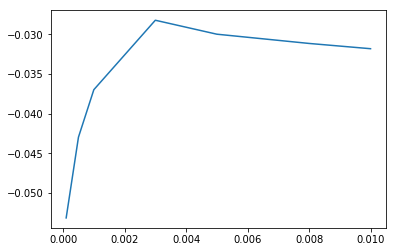

In [212]:
alphas = [1e-4, 5e-4, 1e-3, 3e-3, 5e-3, 8e-3, 1e-2]
cv_lasso = [rmse_cv(linear_model.Lasso(alpha = alpha, max_iter = 50000), X_train, y_train) for alpha in alphas]
pd.Series(cv_lasso, index = alphas).plot()
#X_train.reshape(1,-1)

In [165]:
cv_lasso

[-0.018279687606664704,
 -0.016895698210793557,
 -0.016717232672743266,
 -0.016682380880336082,
 -0.016787421607569745]

In [213]:
clf = linear_model.Lasso(alpha=3e-3, max_iter = 50000).fit(X_train, np.log(y_train))
#clf.fit(X_train, y_train)
predicted = clf.predict(X_val)
predicted[predicted <=0] = 1
#np.log(predicted) - np.log(y_val.values.reshape(-1,1).flatten())
mean_squared_error(predicted, np.log(y_val))


0.050070235780793025

In [214]:
mean_squared_error(clf.predict(X_train), np.log(y_train))

0.016324206780259157

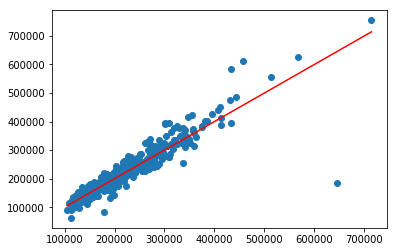

In [215]:
pred_train = np.exp(clf.predict(X_train))
plt.scatter(pred_train, y_train)
plt.plot([min(pred_train),max(pred_train)], [min(pred_train),max(pred_train)], c="red")

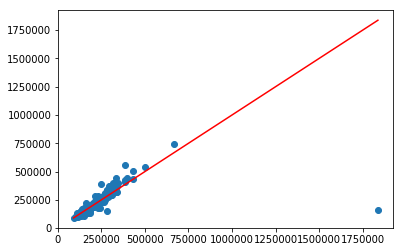

In [216]:
pred_train = np.exp(clf.predict(X_val))
plt.scatter(pred_train, y_val)
plt.plot([min(pred_train),max(pred_train)], [min(pred_train),max(pred_train)], c="red")

Text(0.5,1,'Coefficients in the Model')

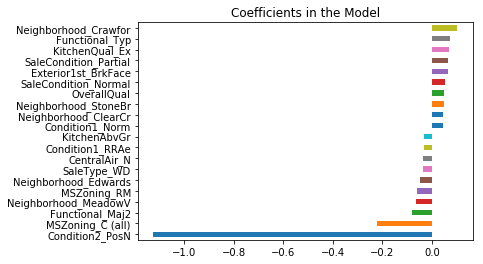

In [156]:
coef = pd.Series(clf.coef_, index = X_train.columns).sort_values()
imp_coef = pd.concat([coef.head(10), coef.tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Model")

In [189]:
X_test = categorical_filtered_dataset[train.shape[0]:][train_columns.tolist()]
X_test.shape
y_test = np.exp(clf.predict(X_test))

test_sol = pd.DataFrame({"id":test.Id, "SalePrice":y_test})
test_sol.to_csv("test_sol.csv", index = False)